### Пример работы библиотеки Optbinning на реальных данных 

### Полезные ссылки:
- Даные: https://github.com/sberbank-ai-lab/LightAutoML/blob/master/examples/data/sampled_app_train.csv
- Документация библиотеки optbinning: https://github.com/guillermo-navas-palencia/optbinning
- Пример моделей построенных с помощью AutoML из репозитория источника даных (на тех же данных): 
    - https://github.com/sberbank-ai-lab/LightAutoML/blob/master/examples/tutorials/Tutorial_1_basics.ipynb
    - https://github.com/sberbank-ai-lab/LightAutoML/blob/master/examples/tutorials/Tutorial_3_sql_data_source.ipynb
    - https://github.com/sberbank-ai-lab/LightAutoML/blob/master/examples/tutorials/Tutorial_6_custom_pipeline.ipynb

### Импортируем библиотеки

In [1]:
import platform
from typing import Any, List, Literal, Optional, Union

import numpy as np
import optbinning as ob
import pandas as pd
import psutil
import sklearn
from sklearn.model_selection import train_test_split
from optbinning.binning.binning_process import BinningProcess

import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns

pd.options.display.max_columns = 150

(CVXPY) Sep 12 02:24:47 PM: Encountered unexpected exception importing solver GLOP:
RuntimeError('Unrecognized new version of ortools (9.6.2534). Expected < 9.5.0.Please open a feature request on cvxpy to enable support for this version.')
(CVXPY) Sep 12 02:24:47 PM: Encountered unexpected exception importing solver PDLP:
RuntimeError('Unrecognized new version of ortools (9.6.2534). Expected < 9.5.0.Please open a feature request on cvxpy to enable support for this version.')


In [2]:
print("OS, Processor:", platform.platform())
print("RAM (gb):", psutil.virtual_memory().total / 2**30)

OS, Processor: macOS-13.5-arm64-arm-64bit
RAM (gb): 16.0


In [3]:
def print_lib_versions(libs: list) -> None:
    """
    Функция вывода имени и версии библиотек
    """
    for lib in libs:
        print(lib.__name__, lib.__version__)


print_lib_versions([pd, np, ob, sns, sklearn, matplotlib])

pandas 1.5.3
numpy 1.24.2
optbinning 0.17.3
seaborn 0.12.2
sklearn 1.2.2
matplotlib 3.7.1


### Загружаем данные

In [4]:
data = pd.read_csv("data/sampled_app_train.csv")
print(data.shape)
data.head()

(10000, 122)


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,313802,0,Cash loans,M,N,Y,0,270000.0,327024.0,15372.0,270000.0,Unaccompanied,Working,Higher education,Married,House / apartment,0.072508,-18590,-226,-2432.0,-2137,NaN,1,1,0,1,0,0,High skill tech staff,2.0,1,1,FRIDAY,14,0,1,1,0,0,0,University,0.867319,0.705511,0.415347,0.0866,0.0000,0.9762,0.6736,0.0246,0.08,0.0345,0.4583,0.5000,0.0000,0.0689,0.0672,0.0077,0.0723,0.0882,0.0000,0.9762,0.6864,0.0248,0.0806,0.0345,0.4583,0.5000,0.0000,0.0753,0.0700,0.0078,0.0765,0.0874,0.0000,0.9762,0.6780,0.0247,0.08,0.0345,0.4583,0.5000,0.0000,0.0701,0.0684,0.0078,0.0738,reg oper account,block of flats,0.0686,Panel,No,0.0,0.0,0.0,0.0,-1275.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,319656,0,Cash loans,F,N,N,0,108000.0,675000.0,19737.0,675000.0,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,0.035792,-20316,-3822,-13156.0,-3758,NaN,1,1,1,1,0,0,Security staff,2.0,2,2,WEDNESDAY,15,0,0,0,0,1,1,Other,NaN,0.545399,0.554947,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,-1732.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,207678,0,Revolving loans,F,Y,Y,2,112500.0,270000.0,13500.0,270000.0,Unaccompanied,Working,Secondary / secondary special,Married,Municipal apartment,0.031329,-9545,-1076,-4077.0,-1058,18.0,1,1,0,1,0,0,Laborers,4.0,2,2,THURSDAY,12,0,0,0,0,0,0,Self-employed,0.296129,0.552184,0.549597,0.0041,NaN,0.9707,NaN,NaN,NaN,0.0345,0.0000,NaN,NaN,NaN,0.0023,NaN,0.0000,0.0042,NaN,0.9707,NaN,NaN,NaN,0.0345,0.0000,NaN,NaN,NaN,0.0024,NaN,0.0000,0.0042,NaN,0.9707,NaN,NaN,NaN,0.0345,0.0000,NaN,NaN,NaN,0.0023,NaN,0.0000,NaN,block of flats,0.0018,Wooden,No,4.0,1.0,4.0

In [5]:
TARGET_NAME = "TARGET"

TECH_COLS = [
    "SK_ID_CURR",
]

CATEGORICAL_COLS = [
    "NAME_CONTRACT_TYPE",
    "CODE_GENDER",
    "NAME_TYPE_SUITE",
    "NAME_INCOME_TYPE",
    "NAME_EDUCATION_TYPE",
    "NAME_FAMILY_STATUS",
    "NAME_HOUSING_TYPE",
    "OCCUPATION_TYPE",
    "REGION_RATING_CLIENT",
    "REGION_RATING_CLIENT_W_CITY",
    "WEEKDAY_APPR_PROCESS_START",
    "HOUR_APPR_PROCESS_START",
    "ORGANIZATION_TYPE",
    "FONDKAPREMONT_MODE",
    "HOUSETYPE_MODE",
    "WALLSMATERIAL_MODE",
]

FLAG_COLS = [
    "FLAG_OWN_CAR",
    "FLAG_OWN_REALTY",
    "FLAG_MOBIL",
    "FLAG_EMP_PHONE",
    "FLAG_WORK_PHONE",
    "FLAG_CONT_MOBILE",
    "FLAG_PHONE",
    "FLAG_EMAIL",
    "REG_REGION_NOT_LIVE_REGION",
    "REG_REGION_NOT_WORK_REGION",
    "LIVE_REGION_NOT_WORK_REGION",
    "REG_CITY_NOT_LIVE_CITY",
    "REG_CITY_NOT_WORK_CITY",
    "LIVE_CITY_NOT_WORK_CITY",
    "EMERGENCYSTATE_MODE",
    "FLAG_DOCUMENT_2",
    "FLAG_DOCUMENT_3",
    "FLAG_DOCUMENT_4",
    "FLAG_DOCUMENT_5",
    "FLAG_DOCUMENT_6",
    "FLAG_DOCUMENT_7",
    "FLAG_DOCUMENT_8",
    "FLAG_DOCUMENT_9",
    "FLAG_DOCUMENT_10",
    "FLAG_DOCUMENT_11",
    "FLAG_DOCUMENT_12",
    "FLAG_DOCUMENT_13",
    "FLAG_DOCUMENT_14",
    "FLAG_DOCUMENT_15",
    "FLAG_DOCUMENT_16",
    "FLAG_DOCUMENT_17",
    "FLAG_DOCUMENT_18",
    "FLAG_DOCUMENT_19",
    "FLAG_DOCUMENT_20",
    "FLAG_DOCUMENT_21",
]

NUMERICAL_COLS = [
    "CNT_CHILDREN",
    "AMT_INCOME_TOTAL",
    "AMT_CREDIT",
    "AMT_ANNUITY",
    "AMT_GOODS_PRICE",
    "REGION_POPULATION_RELATIVE",
    "DAYS_BIRTH",
    "DAYS_EMPLOYED",
    "DAYS_REGISTRATION",
    "DAYS_ID_PUBLISH",
    "OWN_CAR_AGE",
    "CNT_FAM_MEMBERS",
    "APARTMENTS_AVG",
    "BASEMENTAREA_AVG",
    "YEARS_BEGINEXPLUATATION_AVG",
    "YEARS_BUILD_AVG",
    "COMMONAREA_AVG",
    "ELEVATORS_AVG",
    "ENTRANCES_AVG",
    "FLOORSMAX_AVG",
    "FLOORSMIN_AVG",
    "LANDAREA_AVG",
    "LIVINGAPARTMENTS_AVG",
    "LIVINGAREA_AVG",
    "NONLIVINGAPARTMENTS_AVG",
    "NONLIVINGAREA_AVG",
    "APARTMENTS_MODE",
    "BASEMENTAREA_MODE",
    "YEARS_BEGINEXPLUATATION_MODE",
    "YEARS_BUILD_MODE",
    "COMMONAREA_MODE",
    "ELEVATORS_MODE",
    "ENTRANCES_MODE",
    "FLOORSMAX_MODE",
    "FLOORSMIN_MODE",
    "LANDAREA_MODE",
    "LIVINGAPARTMENTS_MODE",
    "LIVINGAREA_MODE",
    "NONLIVINGAPARTMENTS_MODE",
    "NONLIVINGAREA_MODE",
    "APARTMENTS_MEDI",
    "BASEMENTAREA_MEDI",
    "YEARS_BEGINEXPLUATATION_MEDI",
    "YEARS_BUILD_MEDI",
    "COMMONAREA_MEDI",
    "ELEVATORS_MEDI",
    "ENTRANCES_MEDI",
    "FLOORSMAX_MEDI",
    "FLOORSMIN_MEDI",
    "LANDAREA_MEDI",
    "LIVINGAPARTMENTS_MEDI",
    "LIVINGAREA_MEDI",
    "NONLIVINGAPARTMENTS_MEDI",
    "NONLIVINGAREA_MEDI",
    "TOTALAREA_MODE",
    "OBS_30_CNT_SOCIAL_CIRCLE",
    "DEF_30_CNT_SOCIAL_CIRCLE",
    "OBS_60_CNT_SOCIAL_CIRCLE",
    "DEF_60_CNT_SOCIAL_CIRCLE",
    "DAYS_LAST_PHONE_CHANGE",
    "AMT_REQ_CREDIT_BUREAU_HOUR",
    "AMT_REQ_CREDIT_BUREAU_DAY",
    "AMT_REQ_CREDIT_BUREAU_WEEK",
    "AMT_REQ_CREDIT_BUREAU_MON",
    "AMT_REQ_CREDIT_BUREAU_QRT",
    "AMT_REQ_CREDIT_BUREAU_YEAR",
    "EXT_SOURCE_1",
    "EXT_SOURCE_2",
    "EXT_SOURCE_3",
]

In [6]:
# Features we didn't cover
(
    set(data.columns)
    - set([TARGET_NAME])
    - set(TECH_COLS)
    - set(CATEGORICAL_COLS)
    - set(FLAG_COLS)
    - set(NUMERICAL_COLS)
)

set()

### Предобработаем данные

Преобразуем флаги к 1 и 0 (во избежание сайд-эффектов)

In [7]:
def get_prepared_flags(
    value: Union[Any, Literal["Y", "N", "Yes", "No"]]
) -> Union[Any, int]:
    """
    Функция предобработки строковых значений флагов к 0 и 1
    """
        
    if value in ["Y", "Yes"]:
        return 1
    elif value in ["N", "No"]:
        return 0
    else:
        return value

In [8]:
for col in FLAG_COLS:
    data[col] = data[col].apply(lambda x: get_prepared_flags(x))

Заполним pd.nan, np.nan (float) к "NAN" (str) для категоральных факторов (во избежание сайд-эффектов)

In [9]:
data[CATEGORICAL_COLS].isna().sum()

NAME_CONTRACT_TYPE                0
CODE_GENDER                       0
NAME_TYPE_SUITE                  45
NAME_INCOME_TYPE                  0
NAME_EDUCATION_TYPE               0
NAME_FAMILY_STATUS                0
NAME_HOUSING_TYPE                 0
OCCUPATION_TYPE                3138
REGION_RATING_CLIENT              0
REGION_RATING_CLIENT_W_CITY       0
WEEKDAY_APPR_PROCESS_START        0
HOUR_APPR_PROCESS_START           0
ORGANIZATION_TYPE                 0
FONDKAPREMONT_MODE             6809
HOUSETYPE_MODE                 4932
WALLSMATERIAL_MODE             5030
dtype: int64

In [10]:
for col in CATEGORICAL_COLS:
    data[col] = data[col].fillna("NAN")

In [11]:
data[CATEGORICAL_COLS].isna().sum()

NAME_CONTRACT_TYPE             0
CODE_GENDER                    0
NAME_TYPE_SUITE                0
NAME_INCOME_TYPE               0
NAME_EDUCATION_TYPE            0
NAME_FAMILY_STATUS             0
NAME_HOUSING_TYPE              0
OCCUPATION_TYPE                0
REGION_RATING_CLIENT           0
REGION_RATING_CLIENT_W_CITY    0
WEEKDAY_APPR_PROCESS_START     0
HOUR_APPR_PROCESS_START        0
ORGANIZATION_TYPE              0
FONDKAPREMONT_MODE             0
HOUSETYPE_MODE                 0
WALLSMATERIAL_MODE             0
dtype: int64

### Разбиваем на train/test[/val]
В идеальном случае мы бы действительно разбили данные на три выборки. Одну из которых бы использовали для обучения модели, вторую для принятия решений по модели в ходе ее построения, а третью выборку мы бы использовали только для оценки качества. Но с учетом того, что данных в выборке не так много для разбиения, а также для сравнения получивишихся результатов с примерами моделей, разработанных с помощью AutoML, мы разобьем выборку на TRAIN и TEST с аналогичным random_state. При этом в ноутбуке оставим возможным добавление валидационной выборки (но закомментируем не нужный код).

In [12]:
data[[TARGET_NAME]].agg(["count", "sum", "mean"])

,TARGET
count,10000.0000
sum,799.0000
mean,0.0799


In [13]:
def get_target_rate_statistic(df: pd.DataFrame) -> None:
    """
    Функция для вывода статистик по выборке
    """
    print(
        f"{df[TARGET_NAME].count()}",
        f"{df[TARGET_NAME].sum()}",
        f"{round((df[TARGET_NAME].mean())*100, 4)}%",
        sep=" --- ",
    )

In [14]:
X_train, X_test = train_test_split(
    data, test_size=0.2, random_state=42, stratify=data[TARGET_NAME]
)

get_target_rate_statistic(X_train)
get_target_rate_statistic(X_test)

8000 --- 639 --- 7.9875%
2000 --- 160 --- 8.0%


In [15]:
# X_train, X_val = train_test_split(
#     X_train,
#     test_size=0.15 / 0.85,
#     shuffle=True,
#     random_state=52,
#     stratify=X_train[TARGET_NAME],
# )
# get_target_rate_statistic(X_train)
# get_target_rate_statistic(X_val)
# get_target_rate_statistic(X_test)

In [16]:
y_train = X_train[TARGET_NAME]
X_train = X_train.drop(TARGET_NAME, axis=1)

y_test = X_test[TARGET_NAME]
X_test = X_test.drop([TARGET_NAME], axis=1)

In [17]:
# y_val = X_val[TARGET_NAME]
# X_val = X_val.drop(TARGET_NAME, axis=1)

### Обучаем энкодер

In [18]:
print(f"Number of numerical columns: {len(NUMERICAL_COLS + FLAG_COLS)}")
print(f"Number of categorical columns: {len(CATEGORICAL_COLS)}")

assert data.shape[1] == (
    len(NUMERICAL_COLS)
    + len(CATEGORICAL_COLS)
    + len(FLAG_COLS)
    + len([TARGET_NAME])
    + len(TECH_COLS)
)

Number of numerical columns: 104
Number of categorical columns: 16


Задаем параметры для энкодинга

In [19]:
common_params = {
    "solver": "cp",
    "monotonic_trend": "auto",
    "prebinning_method": "cart",
    "divergence": "iv",
    "max_n_prebins": 20,
    "min_prebin_size": 0.05,
    "min_bin_size": 0.05,
    "max_n_bins": 10,
    "min_bin_n_nonevent": 50,
    "min_bin_n_event": 25,
    "max_pvalue_policy": "all",
    "max_pvalue": 0.05,
    "cat_cutoff": 0.05,
}

In [20]:
ob_params = pd.DataFrame(index=NUMERICAL_COLS + FLAG_COLS + CATEGORICAL_COLS)

for parameter, value in common_params.items():
    ob_params[parameter] = value

_ob_params = ob_params.to_dict("index")

for feature, params in _ob_params.items():
    _ob_params[feature] = {
        **params,
        "dtype": "categorical" if feature in CATEGORICAL_COLS else "numerical",
    }

* Обучение WOE-энкодера

In [21]:
features = NUMERICAL_COLS + CATEGORICAL_COLS + FLAG_COLS
print(len(features))

120


In [22]:
optimal_binner = ob.BinningProcess(
    variable_names=features,
    categorical_variables=CATEGORICAL_COLS,
    binning_fit_params=_ob_params,
    verbose=True,
    n_jobs=-1,
)

optimal_binner

BinningProcess(binning_fit_params={'AMT_ANNUITY': {'cat_cutoff': 0.05,
                                                   'divergence': 'iv',
                                                   'dtype': 'numerical',
                                                   'max_n_bins': 10,
                                                   'max_n_prebins': 20,
                                                   'max_pvalue': 0.05,
                                                   'max_pvalue_policy': 'all',
                                                   'min_bin_n_event': 25,
                                                   'min_bin_n_nonevent': 50,
                                                   'min_bin_size': 0.05,
                                                   'min_prebin_size': 0.05,
                                                   'monotonic_trend': 'auto',
                                                   'prebinning_method': 'cart',
                                                   'solver': 'cp'},
                                   'AMT_CREDI...
                               'BASEMENTAREA_AVG',
                               'YEARS_BEGINEXPLUATATION_AVG', 'YEARS_BUILD_AVG',
                               'COMMONAREA_AVG', 'ELEVATORS_AVG',
                               'ENTRANCES_AVG', 'FLOORSMAX_AVG',
                               'FLOORSMIN_AVG', 'LANDAREA_AVG',
                               'LIVINGAPARTMENTS_AVG', 'LIVINGAREA_AVG',
                               'NONLIVINGAPARTMENTS_AVG', 'NONLIVINGAREA_AVG',
                               'APARTMENTS_MODE', 'BASEMENTAREA_MODE',
                               'YEARS_BEGINEXPLUATATION_MODE',
                               'YEARS_BUILD_MODE', ...],
               verbose=True)

In [23]:
optimal_binner.fit(X_train[features], y_train);

2023-09-12 14:24:48,360 | INFO : Binning process started.
2023-09-12 14:24:48,361 | INFO : Options: check parameters.
2023-09-12 14:24:48,362 | INFO : Dataset: number of samples: 8000.
2023-09-12 14:24:48,362 | INFO : Dataset: number of variables: 120.
2023-09-12 14:24:48,362 | INFO : Options: number of jobs (cores): 10.


/Users/kgrushin/Library/Application Support/pypoetry/venv/lib/python3.10/site-packages/optbinning-0.17.3-py3.10.egg/optbinning/binning/binning.py:1086: RuntimeWarning: invalid value encountered in cast
/Users/kgrushin/Library/Application Support/pypoetry/venv/lib/python3.10/site-packages/optbinning-0.17.3-py3.10.egg/optbinning/binning/binning.py:1087: RuntimeWarning: invalid value encountered in cast


2023-09-12 14:24:50,285 | INFO : Binning process variable selection...
2023-09-12 14:24:50,528 | INFO : Binning process terminated. Time: 2.1682s


#### Проверка соблюдения заданных критериев для обучения

In [24]:
def get_binned_table(
    optimal_binner: ob.BinningProcess, features: List[str]
) -> pd.DataFrame:
    """
    Функция для получения таблицы с результатами биннинга
    """

    common_table = pd.DataFrame()
    for feature in features:
        table = optimal_binner.get_binned_variable(feature).binning_table.build()
        table = table.loc[(table["Count"] > 0) & (table.index != "Totals")]

        table["bin_has_problem"] = np.where(
            (
                (table["Count (%)"] < 0.05)
                | (table["Event"] < 25)
                | (table["Non-event"] < 50)
            ),
            1,
            0,
        )

        table["feature"] = feature
        assert table.loc[table.index != "Totals"]["Count"].sum() == X_train.shape[0]
        assert (
            round(table.loc[table.index != "Totals"]["Count (%)"].sum(), 2) == 1
        ), table
        common_table = pd.concat([common_table, table], axis=0)

    return common_table

In [25]:
binned_table = get_binned_table(optimal_binner, features)
print(binned_table.shape)
binned_table.head(5)

(288, 11)


,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS,bin_has_problem,feature
0,"(-inf, inf)",8000,1.000000,7361,639,0.079875,0.0,0.000000,0.000000,0,CNT_CHILDREN
0,"(-inf, 294075.00)",7407,0.925875,6794,613,0.082760,-0.038616,0.001403,0.000175,0,AMT_INCOME_TOTAL
1,"[294075.00, inf)",593,0.074125,567,26,0.043845,0.638216,0.023192,0.002851,0,AMT_INCOME_TOTAL
0,"(-inf, 307354.50)",2432,0.304000,2254,178,0.073191,0.094632,0.002616,0.000327,0,AMT_CREDIT
1,"[307354.50, 359084.25)",426,0.053250,369,57,0.133803,-0.576301,0.022518,0.002776,0,AMT_CREDIT


In [26]:
binned_table[binned_table["bin_has_problem"] == 1]

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS,bin_has_problem,feature
4,Missing,8,0.001000,7,1,0.125000,-0.498136,0.000306,0.000038,1,AMT_GOODS_PRICE
3,Missing,31,0.003875,30,1,0.032258,0.957151,0.002403,0.000289,1,OBS_30_CNT_SOCIAL_CIRCLE
3,Missing,31,0.003875,30,1,0.032258,0.957151,0.002403,0.000289,1,DEF_30_CNT_SOCIAL_CIRCLE
3,Missing,31,0.003875,30,1,0.032258,0.957151,0.002403,0.000289,1,OBS_60_CNT_SOCIAL_CIRCLE
2,Missing,31,0.003875,30,1,0.032258,0.957151,0.002403,0.000289,1,DEF_60_CNT_SOCIAL_CIRCLE
7,Missing,21,0.002625,19,2,0.095238,-0.192755,0.000106,0.000013,1,EXT_SOURCE_2
3,"[Businessman, Unemployed]",3,0.000375,3,0,0.000000,0.0,0.000000,0.000000,1,NAME_INCOME_TYPE
2,"[Incomplete higher, Lower secondary, Academic ...",344,0.043000,311,33,0.095930,-0.200761,0.001886,0.000235,1,NAME_EDUCATION_TYPE
2,"[specific housing, terraced house]",79,0.009875,68,11,0.139241,-0.622434,0.004965,0.000611,1,HOUSETYPE_MODE


In [27]:
optimal_binning_summary = optimal_binner.summary()

In [28]:
optimal_binning_summary["has_problem"] = np.where(
    optimal_binning_summary["name"].isin(
        binned_table[binned_table["bin_has_problem"] == 1]["feature"].to_list()
    ),
    1,
    0,
)

In [29]:
optimal_binning_summary.loc[optimal_binning_summary["has_problem"] == 1]

,name,dtype,status,selected,n_bins,iv,js,gini,quality_score,has_problem
4,AMT_GOODS_PRICE,numerical,OPTIMAL,True,3,0.088155,0.010878,0.143909,0.264089,1
55,OBS_30_CNT_SOCIAL_CIRCLE,numerical,OPTIMAL,True,2,0.028761,0.003558,0.053465,0.027738,1
56,DEF_30_CNT_SOCIAL_CIRCLE,numerical,OPTIMAL,True,2,0.009118,0.001127,0.029659,0.010276,1
57,OBS_60_CNT_SOCIAL_CIRCLE,numerical,OPTIMAL,True,2,0.029712,0.003675,0.054279,0.02845,1
58,DEF_60_CNT_SOCIAL_CIRCLE,numerical,OPTIMAL,True,1,0.002409,0.00029,0.002511,0.000116,1
67,EXT_SOURCE_2,numerical,OPTIMAL,True,6,0.376931,0.045432,0.334493,0.895203,1
72,NAME_INCOME_TYPE,categorical,OPTIMAL,True,4,0.067065,0.00833,0.131112,0.198927,1
73,NAME_EDUCATION_TYPE,categorical,OPTIMAL,True,3,0.03379,0.004207,0.078547,0.075941,1
83,HOUSETYPE_MODE,categorical,OPTIMAL,True,3,0.045158,0.005626,0.105685,0.119091,1


### Оставляем лучшие факторы для дальнейшего рассмотрения

In [30]:
print(optimal_binning_summary.shape)
ob_summary_best = optimal_binning_summary.query("iv > 0.05 or gini > 0.05")
print(ob_summary_best.shape)
ob_summary_best.head()

(120, 10)
(80, 10)


,name,dtype,status,selected,n_bins,iv,js,gini,quality_score,has_problem
2,AMT_CREDIT,numerical,OPTIMAL,True,4,0.060132,0.007455,0.126416,0.198736,0
3,AMT_ANNUITY,numerical,OPTIMAL,True,3,0.038833,0.004809,0.09073,0.114798,0
4,AMT_GOODS_PRICE,numerical,OPTIMAL,True,3,0.088155,0.010878,0.143909,0.264089,1
5,REGION_POPULATION_RELATIVE,numerical,OPTIMAL,True,3,0.033487,0.004163,0.088192,0.101978,0
6,DAYS_BIRTH,numerical,OPTIMAL,True,4,0.152115,0.018758,0.209574,0.50421,0


Пример разбивки факторов, с низким качеством

In [31]:
binned_table.loc[binned_table["feature"] == "CNT_CHILDREN"]

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS,bin_has_problem,feature
0,"(-inf, inf)",8000,1.0,7361,639,0.079875,0.0,0.0,0.0,0,CNT_CHILDREN


In [32]:
binned_table.loc[binned_table["feature"] == "AMT_INCOME_TOTAL"]

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS,bin_has_problem,feature
0,"(-inf, 294075.00)",7407,0.925875,6794,613,0.082760,-0.038616,0.001403,0.000175,0,AMT_INCOME_TOTAL
1,"[294075.00, inf)",593,0.074125,567,26,0.043845,0.638216,0.023192,0.002851,0,AMT_INCOME_TOTAL


### Трансформируем данные

In [33]:
X_train_enc = optimal_binner.transform(
    X_train,
    metric="woe",
    metric_special="empirical",
    metric_missing="empirical",
)


X_test_enc = optimal_binner.transform(
    X_test,
    metric="woe",
    metric_special="empirical",
    metric_missing="empirical",
)

print(
    X_train_enc.shape,
    X_test_enc.shape,
)

(8000, 120) (2000, 120)


In [34]:
# X_val_enc = optimal_binner.transform(
#     X_val,
#     metric="woe",
#     metric_special="empirical",
#     metric_missing="empirical",
# )

# print(
#     X_val_enc.shape,
# )

Сбросим индексы массивов с таргетами (после трансформации optimal_binner эта информация потеряна для данных с факторами)

In [35]:
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

In [36]:
# y_val = y_val.reset_index(drop=True)

Оставим только лучшие факторы

In [37]:
best_features = ob_summary_best["name"].to_list()

In [38]:
X_train_enc = X_train_enc[best_features].copy()
X_test_enc = X_test_enc[best_features].copy()

print(
    X_train_enc.shape,
    X_test_enc.shape,
)

(8000, 80) (2000, 80)


In [39]:
# X_val_enc = X_val_enc[best_features].copy()

# print(
#     X_val_enc.shape,
# )

### Находим оптимальное признаковое пространство (строим модели)

Сделать это можно несколькими способами:
 - используя *[optbinning.scorecard.Scorecard](http://gnpalencia.org/optbinning/scorecard.html)*;
 - используя любую другую реализацию модели.
    
Вариант с использованием *optbinning.scorecard.Scorecard* в данном случае не подойдет, так как мы хотим уменьшить наше пространство факторов (80 факторов, потенциально дублирующих информацию – это много для простой линейной модели), при этом контролируя показатели корреляции, знаков коэффициентов логистической регрессии и их p-value. Когда отберем факторы и обучим итоговую модель - можем ее передать в объект Scorecard для представления итоговой модели в виде скоринговой карты, если посчитаем нужным.

Мы же сейчас воспользуемся библиотекой *statsmodels* и реализацией **логистической регрессии** из нее со встроенной оценкой p-value. При этом сокращать факторы мы будем с помощью stepwise подхода.



In [40]:
import datetime as dt
from itertools import combinations
from typing import Any, Dict, List, Literal, Optional, Tuple

import matplotlib.ticker as mtick
import numpy as np
import pandas as pd
import statsmodels.api as sm
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score, roc_curve
from statsmodels.stats.outliers_influence import variance_inflation_factor


def gini(y_true, y_pred):
    """Функция для оценки GINI"""
    return 2 * roc_auc_score(y_true, y_pred) - 1


def get_high_correlation_flag(
    corrs: pd.DataFrame, features: List[str], correlation_threshold: float
) -> bool:
    """
    Функция для проверки наличия корреляций для features выше чем correlation_threshold
    """

    corrs_features = corrs.loc[features][features]

    return (
        (
            corrs_features.where(
                np.triu(np.ones(corrs_features.shape), k=1).astype(bool)
            )
            > correlation_threshold
        )
        .any()
        .any()
    )


def get_vif_is_bad_flag(
    data: pd.DataFrame, features: List[str], vif_treshold: float
) -> bool:
    """Функция для проверки VIF и соответствия заданному vif_treshold"""
    if len(features) > 1:
        if any(
            [
                vif > vif_treshold
                for vif in [
                    variance_inflation_factor(data[features].values, i)
                    for i in range(len(features))
                ]
            ]
        ):
            return True
    return False


class NeedContinue(Exception):
    ...


class NeedBreak(Exception):
    ...


def learn_model_make_preds_and_get_model_and_metrics(
    considering_combination: List[str],
    X_train: pd.DataFrame,
    y_train: pd.DataFrame,
    X_val: pd.DataFrame,
    y_val: pd.DataFrame,
    X_test: Optional[pd.DataFrame] = None,
    y_test: Optional[pd.DataFrame] = None,
) -> Tuple[sm.Logit, float, float, Optional[float]]:
    """Функция обучения модели, предсказания и оценки gini"""

    model = sm.Logit(y_train, sm.add_constant(X_train[considering_combination])).fit(
        disp=0, method="bfgs", maxiter=150
    )

    y_pred_train = model.predict(sm.add_constant(X_train[considering_combination]))
    y_pred_val = model.predict(sm.add_constant(X_val[considering_combination]))
    if X_test is not None:
        y_pred_test = model.predict(sm.add_constant(X_test[considering_combination]))
    else:
        y_pred_test = None

    gini_train = gini(y_train, y_pred_train)
    gini_val = gini(y_val, y_pred_val)
    if (X_test is not None) & (y_test is not None):
        gini_test = gini(y_test, y_pred_test)
    else:
        gini_test = None

    return model, gini_train, gini_val, gini_test


def make_step(
    step_type: Literal["forward", "backward"],
    X_train: pd.DataFrame,
    y_train: pd.DataFrame,
    X_val: pd.DataFrame,
    y_val: pd.DataFrame,
    X_test: Optional[pd.DataFrame],
    y_test: Optional[pd.DataFrame],
    _n: int,
    verbose: int,
    considering_feature: str,
    best_combination: List[str],
    modeling_result: List[Dict[str, Any]],
    corrs: pd.DataFrame,
    correlation_threshold: float,
    p_value_threshold: float,
    vif_treshold: float,
) -> List[Dict[str, Any]]:
    """Функция для шагов forward/backward в рамках stepwise-регрессии"""

    if ((_n + 1) % verbose) == 0:
        print(f"Considering {_n+1} features in {step_type} step -- {dt.datetime.now()}")

    if step_type == "forward":
        if considering_feature in best_combination:
            raise NeedContinue
        considering_combination = best_combination + [considering_feature]
    elif step_type == "backward":
        considering_combination = list(best_combination)
        # Change the previous factor
        considering_combination[len(considering_combination) - 2] = considering_feature
    else:
        raise ValueError(f"Type of step can't be {step_type}")

    if get_high_correlation_flag(corrs, considering_combination, correlation_threshold):
        raise NeedContinue

    (
        model,
        gini_train,
        gini_val,
        gini_test,
    ) = learn_model_make_preds_and_get_model_and_metrics(
        considering_combination=considering_combination,
        X_train=X_train,
        y_train=y_train,
        X_val=X_val,
        y_val=y_val,
        X_test=X_test,
        y_test=y_test,
    )

    if (model.pvalues.values > p_value_threshold).any():
        raise NeedContinue

    # coef > 0 (only for WoE)
    if any([i > 0 for i in model.params[1:]]):
        raise NeedContinue

    # check VIF
    if get_vif_is_bad_flag(X_train, considering_combination, vif_treshold):
        raise NeedContinue

    modeling_result.append(
        {
            "cnt_factors": len(considering_combination),
            "considering_combination": considering_combination,
            "gini_train": gini_train,
            "gini_val": gini_val,
            "gini_test": gini_test,
            "gini_train_val_avg": (gini_train + gini_val) / 2,
        }
    )
    return modeling_result


def check_result_is_not_empty(result_df: pd.DataFrame, cnt_factors: int) -> None:
    """Функция для проверки наличия данных в result_df для соответствующего количества факторов cnt_factors"""
    if result_df[result_df.cnt_factors == cnt_factors].empty:
        print(
            f"We couldn't produce model with {cnt_factors} features on forward step. "
            "There is no feature to combinate that satisfies our conditions."
        )
        raise NeedBreak


def select_the_best_combination(
    result_df: pd.DataFrame,
    cnt_factors: int,
    sorted_by: Literal["gini_train_val_avg", "gini_val", "gini_train"],
) -> List[str]:
    """Функция для выбора лучшей комбинации по показателям cnt_factors и sorted_by"""
    return (
        result_df.loc[result_df.cnt_factors == cnt_factors]
        .sort_values(sorted_by, ascending=False)
        .iloc[0]["considering_combination"]
    )


def check_data(
    X_train: pd.DataFrame,
    X_val: pd.DataFrame,
    X_test: Optional[pd.DataFrame],
    y_train: pd.DataFrame,
    y_val: pd.DataFrame,
    y_test: Optional[pd.DataFrame],
) -> None:
    """Функция для проверки входных данных"""

    if not (len(X_train.columns) == len(X_val.columns)):
        raise ValueError("Length of columns X_train, X_val should be equal.")

    if not ((len(X_train) == len(y_train)) & (len(X_val) == len(y_val))):
        raise ValueError(
            "Length of X_train, y_train (or X_val, y_val) should be equal."
        )

    if X_test is not None:
        if not (len(X_train.columns) == len(X_test.columns)):
            raise ValueError("Length of columns X_train, X_test should be equal.")

        if not (len(X_test) == len(y_test)):
            raise ValueError("Length of X_test, y_test should be equal.")


def get_correlation_matrix(data: pd.DataFrame):
    """Функция для оценки коррялций методом Спирмена"""
    return data.corr(method="spearman", numeric_only=True)

In [41]:
def build_stepwise_models(
    X_train: pd.DataFrame,
    y_train: pd.DataFrame,
    X_val: pd.DataFrame,
    y_val: pd.DataFrame,
    X_test: Optional[pd.DataFrame] = None,
    y_test: Optional[pd.DataFrame] = None,
    correlation_threshold: float = 0.7,
    vif_treshold: float = 4.0,
    p_value_threshold: float = 0.05,
    verbose: int = 50,
    n_max_factors: Optional[int] = None,
) -> pd.DataFrame:
    """Функция для построения stepwise-регрессии"""

    if not n_max_factors:
        n_max_factors = len(X_train.columns)

    check_data(X_train, X_val, X_test, y_train, y_val, y_test)

    modeling_result = []
    best_combination = []
    result_df = pd.DataFrame()

    # Get correlation matrix
    corrs = get_correlation_matrix(X_train)

    for i in range(1, n_max_factors + 1):

        print(f"Building {i}-factor models -- {dt.datetime.now()}")

        # Forward steps
        for _n, feature in enumerate(X_train.columns):
            try:
                modeling_result = make_step(
                    step_type="forward",
                    X_train=X_train,
                    y_train=y_train,
                    X_val=X_val,
                    y_val=y_val,
                    X_test=X_test,
                    y_test=y_test,
                    _n=_n,
                    verbose=verbose,
                    considering_feature=feature,
                    best_combination=best_combination,
                    modeling_result=modeling_result,
                    corrs=corrs,
                    correlation_threshold=correlation_threshold,
                    p_value_threshold=p_value_threshold,
                    vif_treshold=vif_treshold,
                )
            except NeedContinue:
                continue

        # Save results
        result_df = pd.DataFrame(modeling_result)

        # Check that we produced at least one model with i considering features.
        try:
            check_result_is_not_empty(result_df, cnt_factors=i)
        except NeedBreak:
            break

        # Define the best combination of features
        best_combination = select_the_best_combination(
            result_df, cnt_factors=i, sorted_by="gini_train_val_avg"
        )

        # If it's 1 feature model we can't reduce number of features
        if i == 1:
            continue

        # Backward step
        for _n, feature in enumerate(X_train.columns):
            try:
                modeling_result = make_step(
                    step_type="backward",
                    X_train=X_train,
                    y_train=y_train,
                    X_val=X_val,
                    y_val=y_val,
                    X_test=X_test,
                    y_test=y_test,
                    _n=_n,
                    verbose=verbose,
                    considering_feature=feature,
                    best_combination=best_combination,
                    modeling_result=modeling_result,
                    corrs=corrs,
                    correlation_threshold=correlation_threshold,
                    p_value_threshold=p_value_threshold,
                    vif_treshold=vif_treshold,
                )
            except NeedContinue:
                continue

        # Save results
        result_df = pd.DataFrame(modeling_result)

        # Define the best combination of features
        best_combination = select_the_best_combination(
            result_df, cnt_factors=i, sorted_by="gini_train_val_avg"
        )

    return result_df

Проведем stepwise-регрессию. При этом передадим в обязательный аргумент X_val тестовую выборку. А в качестве тестовой передадим None. В случае появления валидационной выборки в X_val следует передавать валидационную выборку, а в X_test выборку тестовую.

In [42]:
%%time
stepwise_results = build_stepwise_models(
    X_train=X_train_enc,
    y_train=y_train,
    X_val=X_test_enc,
    y_val=y_test,
    X_test=None,
    y_test=None,
    correlation_threshold=0.7,
    vif_treshold=4,
    p_value_threshold=0.05,
    verbose=10,
    n_max_factors=25,
)

Building 1-factor models -- 2023-09-12 14:24:51.193428
Considering 10 features in forward step -- 2023-09-12 14:24:51.320201
Considering 20 features in forward step -- 2023-09-12 14:24:51.532818
Considering 30 features in forward step -- 2023-09-12 14:24:51.682590
Considering 40 features in forward step -- 2023-09-12 14:24:51.880306
Considering 50 features in forward step -- 2023-09-12 14:24:52.097409
Considering 60 features in forward step -- 2023-09-12 14:24:52.261553
Considering 70 features in forward step -- 2023-09-12 14:24:52.469929
Considering 80 features in forward step -- 2023-09-12 14:24:52.632230
Building 2-factor models -- 2023-09-12 14:24:52.649709
Considering 10 features in forward step -- 2023-09-12 14:24:53.145597
Considering 20 features in forward step -- 2023-09-12 14:24:53.324119
Considering 30 features in forward step -- 2023-09-12 14:24:53.557443
Considering 40 features in forward step -- 2023-09-12 14:24:53.751823
Considering 50 features in forward step -- 2023-09

Выгружаем все построенные модели в рамках степвайз

In [43]:
print(stepwise_results.shape)
stepwise_results.to_excel("outputs/stepwise_results.xlsx", index=False)

(1126, 6)


Получим лучшие модели по итогам степвайз

In [44]:
def get_best_models_df(stepwise_results: pd.DataFrame, sort_by: str, gain_cutoff: float = 0.003) -> pd.DataFrame:
    """
    Функция для получения перечня моделей с лучшим качеством для каждого # факторов 
    по sort_by исходя из результатов построения моделей в ходе stepwise
    """
                       
    stepwise_result_best = pd.DataFrame(columns=stepwise_results.columns)
    for n_factors in range(stepwise_results.cnt_factors.max(), 0, -1):
        stepwise_result_best = pd.concat(
            [
                stepwise_result_best,
                stepwise_results[stepwise_results["cnt_factors"] == n_factors]
                .sort_values(sort_by, ascending=False)
                .iloc[:1],
            ]
        )
        
    # Оценка gain метрики с увеличением количества факторов
    stepwise_result_best = stepwise_result_best.sort_values(by=["cnt_factors"])
    for col in ["train", "val","test","train_val_avg",]:
        try:
            stepwise_result_best[f"gain_{col}"] = stepwise_result_best[f"gini_{col}"].diff()
            stepwise_result_best[f"gain_{col}_is_good"] = (stepwise_result_best[f"gain_{col}"] > gain_cutoff).astype(int)
        except TypeError:
            stepwise_result_best[f"gain_{col}"] = None
            stepwise_result_best[f"gain_{col}_is_good"] = None
        
    return stepwise_result_best

In [45]:
stepwise_result_best = get_best_models_df(stepwise_results, "gini_train_val_avg", gain_cutoff=0.003)

In [46]:
print(stepwise_result_best.shape)
stepwise_result_best.to_excel("outputs/stepwise_result_best.xlsx", index=False)

(14, 14)


In [47]:
stepwise_result_best

,cnt_factors,considering_combination,gini_train,gini_val,gini_test,gini_train_val_avg,gain_train,gain_train_is_good,gain_val,gain_val_is_good,gain_test,gain_test_is_good,gain_train_val_avg,gain_train_val_avg_is_good
61,1,[EXT_SOURCE_2],0.334493,0.308431,None,0.321462,NaN,0,NaN,0,None,None,NaN,0
140,2,"[EXT_SOURCE_2, EXT_SOURCE_3]",0.432777,0.423621,None,0.428199,0.098284,1,0.115190,1,None,None,0.106737,1
296,3,"[EXT_SOURCE_2, EXT_SOURCE_3, EXT_SOURCE_1]",0.455950,0.449260,None,0.452605,0.023173,1,0.025639,1,None,None,0.024406,1
524,4,"[EXT_SOURCE_2, EXT_SOURCE_3, EXT_SOURCE_1, OCC...",0.470075,0.463906,None,0.466991,0.014125,1,0.014647,1,None,None,0.014386,1
660,5,"[EXT_SOURCE_2, EXT_SOURCE_3, EXT_SOURCE_1, OCC...",0.483757,0.464484,None,0.474120,0.013682,1,0.000577,0,None,None,0.007130,1
735,6,"[EXT_SOURCE_2, EXT_SOURCE_3, EXT_SOURCE_1, OCC...",0.490359,0.468414,None,0.479386,0.006602,1,0.003930,1,None,None,0.005266,1
853,7,"[EXT_SOURCE_2, EXT_SOURCE_3, EXT_SOURCE_1, OCC...",0.496717,0.471987,None,0.484352,0.006358,1,0.003573,1,None,None,0.004966,1
996,8,"[EXT_SOURCE_2, EXT_SOURCE_3, EXT_SOURCE_1, OCC...",0.505009,0.471946,None,0.488478,0.008292,1,-0.000041,0,None,None,0.004125,1
1039,9,"[EXT_SOURCE_2, EXT_SOURCE_3, EXT_SOURCE_1, OCC...",0.507170,0.477137,None,0.492153,0.002161,0,0.005190,1,None,None,0.003676,1
1078,10,"[EXT_SOURCE_2, EXT_SOURCE_3, EXT_SOURCE_1, OCC...",0.507450,0.478923,None,0.493186,0.000280,0,0.001787,0,None,None,0.001033,0


В теории если понимаем, что у данных есть потенциал к качеству выше и фичей может быть больше чем в лучшей модели, то можем вернуться на этап отбора лучших факторов и снизить жесткость фильтрации.

### Прирост GINI

In [48]:
def plot_gini_gain(
    results: pd.DataFrame,
    gain_cutoff: float,
    target_rate:float,
) -> None:
    """
    Функция для построения графика роста GINI с ростом кол-ва факторов
    """
    
    target_rate = round(target_rate * 100, 2)
    plt.style.use("default")
    fig, ax = plt.subplots()
    fig.set_figheight(6)
    fig.set_figwidth(10)

    ax2 = ax.twinx()
    
    colorset = {
        'train': '#112a33',
        'val': '#1a6985',
        'test': '#6c38aa',
        'train_val_avg': '#92cbdf',
    }
    
    gain_colorset = {
        'train': '#64DE89',
        'val': '#00BD39',
        'test': '#007B25',
        'train_val_avg': '#007B25',
    }
    
    for subsample in ['train', 'val', 'test', 'train_val_avg']:
        
        ax.plot(
            range(1, len(results) + 1),
            results[f"gini_{subsample}"],
            label=f"Gini {subsample.upper()}",
            color=colorset[subsample],
        )
    
    for subsample in ['train', 'val', 'test', 'train_val_avg']:
        
        ax2.plot(
            range(1, len(results) + 1),
            results[f"gain_{subsample}"],
            label=f"Gain {subsample.upper()}",
            color=gain_colorset[subsample],
            linestyle="dotted",
        )

    ax2.plot(
        range(1, len(results) + 1),
        [gain_cutoff for _ in range(len(results))],
        "--",
        label="Gain Cutoff",
        color="red",
    )

    ax.grid(axis="both")
    ax.legend(loc="upper right")
    ax2.legend(loc="upper left")
    ax.set_xlabel("Число факторов")
    ax.set_ylabel("Gini")
    ax2.set_ylabel("Gain Gini")
    plt.title("Динамика Gini с увеличением числа факторов (лучшие модели)")
    plt.show()

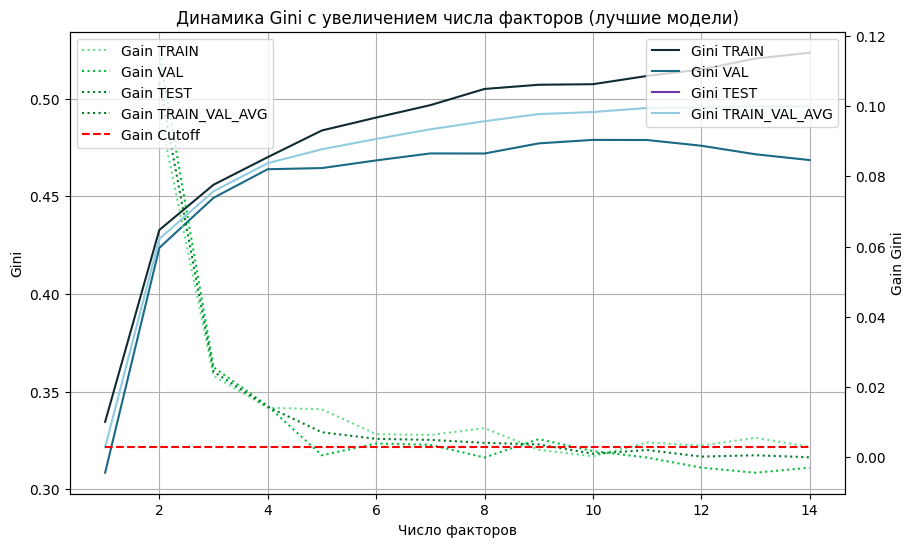

In [49]:
plot_gini_gain(stepwise_result_best, 0.003, target_rate=y_train.sum()/y_train.shape[0])

Выберем модель с 8 факторами, так как прирост на выборке обучения практически останавливается в данной точке (ниже нашего cutoff). 

In [50]:
def get_the_best_combination(n_features:int, stepwise_result_best:pd.DataFrame) -> List[str]:
    """Функция возвращает комбинацию с заданным кол-вом факторов"""
    return stepwise_result_best.loc[stepwise_result_best['cnt_factors'] == n_features]['considering_combination'].iloc[0]                                                       

In [51]:
best_combination = get_the_best_combination(
    n_features=8, stepwise_result_best=stepwise_result_best
)
print(len(best_combination), best_combination)

8 ['EXT_SOURCE_2', 'EXT_SOURCE_3', 'EXT_SOURCE_1', 'OCCUPATION_TYPE', 'DAYS_BIRTH', 'AMT_GOODS_PRICE', 'WEEKDAY_APPR_PROCESS_START', 'BASEMENTAREA_MEDI']


In [52]:
def get_the_best_model(
    best_combination: List[str],
    X_train: pd.DataFrame,
    y_train: pd.DataFrame,
) -> sm.Logit:
    """Функция для обучения модели sm.Logit"""
    
    # Построение модели
    clf = sm.Logit(
        y_train,
        sm.add_constant(X_train[best_combination]),
    )
    fitted_clf = clf.fit(disp=0, method="bfgs", maxiter=150)
    
    return fitted_clf

In [53]:
the_best_model = get_the_best_model(
    best_combination=best_combination, 
    X_train=X_train_enc,
    y_train=y_train,
)
the_best_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 TARGET   No. Observations:                 8000
Model:                          Logit   Df Residuals:                     7991
Method:                           MLE   Df Model:                            8
Date:                Tue, 12 Sep 2023   Pseudo R-squ.:                  0.1097
Time:                        14:30:14   Log-Likelihood:                -1983.4
converged:                       True   LL-Null:                       -2227.7
Covariance Type:            nonrobust   LLR p-value:                2.013e-100
==============================================================================================
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                         -2.4443      0.046    -53.625      0.000      -2.534      -2.355
EXT_SOURCE_2                  -0.8183      0.072    -11.359      0.000      -0.959      -0.677
EXT_SOURCE_3                  -0.8307      0.078    -10.679      0.000      -0.983      -0.678
EXT_SOURCE_1                  -0.4674      0.121     -3.863      0.000      -0.704      -0.230
OCCUPATION_TYPE               -0.5630      0.162     -3.484      0.000      -0.880      -0.246
DAYS_BIRTH                    -0.4353      0.120     -3.617      0.000      -0.671      -0.199
AMT_GOODS_PRICE               -0.5912      0.141     -4.181      0.000      -0.868      -0.314
WEEKDAY_APPR_PROCESS_START    -1.1436      0.345     -3.319      0.001      -1.819      -0.468
BASEMENTAREA_MEDI             -0.8482      0.206     -4.120      0.000      -1.252      -0.445
==============================================================================================
"""

Все коэффициенты отрицательны, что логично с точки зрения логики наших факторов (WoE чем ниже, тем хуже). Все p-value проходят cutoff в 5%.

In [54]:
def get_main_stats_for_the_best_model(
    clf: sm.Logit,
    best_combination: List[str],
    X_train: pd.DataFrame,
    y_train: pd.DataFrame,
    X_val: pd.DataFrame,
    y_val: pd.DataFrame,
    X_test: Optional[pd.DataFrame] = None,
    y_test: Optional[pd.DataFrame] = None,
) -> pd.DataFrame:
    """Функция для получения основных метрик по обученной модели"""
    
    # Оценка корреляций
    corrs = get_correlation_matrix(X_train[best_combination])
    mask = np.zeros_like(corrs)
    mask[np.triu_indices_from(mask)] = True
    sns.heatmap(corrs.round(2), annot=True, cmap="YlGnBu", mask=mask);
    
    # Оценка VIF
    vif_df = pd.DataFrame(
        [
            variance_inflation_factor(X_train[best_combination].values, i)
            for i in range(len(best_combination))
        ],
        index=best_combination,
        columns=["VIF"],
    )
    
    # Формирование прогноза
    y_pred_train = clf.predict(sm.add_constant(X_train[best_combination]))
    y_pred_val = clf.predict(sm.add_constant(X_val[best_combination]))
    y_pred_test = clf.predict(sm.add_constant(X_test[best_combination])) if X_test is not None else np.nan
    
    # Оценка качества
    gini_train = gini(y_train, y_pred_train)
    gini_val = gini(y_val, y_pred_val)
    gini_test = gini(y_test, y_pred_test) if y_test is not None else np.nan
    
    print(f'GINI Train {gini_train}', f'GINI Val {gini_val}', f'GINI Test {gini_test}', sep='\n')
    
    return vif_df

GINI Train 0.5050087389041642
GINI Val 0.4719463315217389
GINI Test nan


,VIF
EXT_SOURCE_2,1.084182
EXT_SOURCE_3,1.071478
EXT_SOURCE_1,1.078914
OCCUPATION_TYPE,1.127213
DAYS_BIRTH,1.180833
AMT_GOODS_PRICE,1.045749
WEEKDAY_APPR_PROCESS_START,1.001999
BASEMENTAREA_MEDI,1.015872


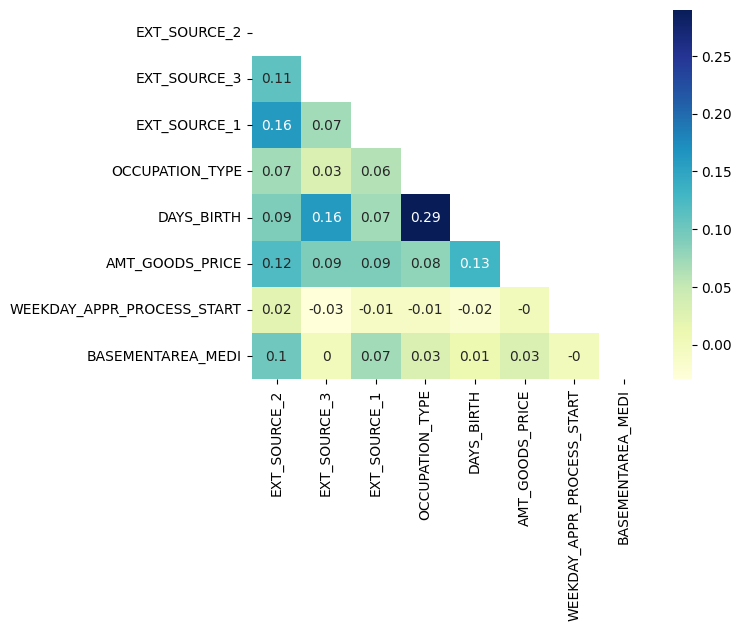

In [55]:
vif_result = get_main_stats_for_the_best_model(
    clf=the_best_model,
    best_combination=best_combination, 
    X_train=X_train_enc,
    y_train=y_train,
    X_val=X_test_enc,
    y_val=y_test,
    X_test=None,
    y_test=None,
)
vif_result

Значение VIF и корреляций также удовлетворяют условиям построения качественной модели

### Корректируем биннинг

In [56]:
binned_table.loc[
    binned_table['feature'].isin(best_combination)
]

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS,bin_has_problem,feature
0,"(-inf, 375750.00)",3230,0.403750,2965,265,0.082043,-0.029144,0.000347,0.000043,0,AMT_GOODS_PRICE
1,"[375750.00, 452250.00)",883,0.110375,757,126,0.142695,-0.650965,0.061415,0.007544,0,AMT_GOODS_PRICE
2,"[452250.00, inf)",3879,0.484875,3632,247,0.063676,0.244104,0.026087,0.003253,0,AMT_GOODS_PRICE
4,Missing,8,0.001000,7,1,0.125000,-0.498136,0.000306,0.000038,1,AMT_GOODS_PRICE
0,"(-inf, -20312.50)",1636,0.204500,1569,67,0.040954,0.709455,0.076833,0.009408,0,DAYS_BIRTH
1,"[-20312.50, -17298.00)",1431,0.178875,1344,87,0.060797,0.293451,0.013626,0.001697,0,DAYS_BIRTH
2,"[-17298.00, -13055.50)",2511,0.313875,2307,204,0.081243,-0.018463,0.000108,0.000013,0,DAYS_BIRTH
3,"[-13055.50, inf)",2422,0.302750,2141,281,0.116020,-0.413373,0.061548,0.007639,0,DAYS_BIRTH
0,"(-inf, 0.06)",1237,0.154625,1133,104,0.084074,-0.055813,0.000493,0.000062,0,BASEMENTAREA_MEDI
1,"[0.06, inf)",2150,0.268750,2032,118,0.054884,0.402045,0.036741,0.004562,0,BASEMENTAREA_MEDI


1) Если пропущенных значений недостаточно для оценки, то консервативно определяем их в группу с худшим значением (значение соответствующее наиболее высокому target rate). Здесь важно отметить, что так мы делаем исходя из предположений о том, что 1 соответствует негативному событию (которое мы хотим спрогнозировать) и о том, что нам лучше допустить ошибку 1 рода (ложно положительный исход).
    1) EXT_SOURCE_2
    2) AMT_GOODS_PRICE
2) Недостаточное количество наблюдений в группе может привести к получению нестабильных результатов при промышленном применении модели, поэтому такие группы мы объединяем со смежными по уровню целевого события также консервативно.
    - Таких кейсов нет
    
В остальном наши факторы получились достаточно логичными, без явных изъянов.

In [57]:
# Для реализации задуманного заменим пропуски в факторе EXT_SOURCE_2 на -1.
X_train['EXT_SOURCE_2'] = X_train['EXT_SOURCE_2'].fillna(-1)
# X_val['EXT_SOURCE_2'] = X_val['EXT_SOURCE_2'].fillna(-1)
X_test['EXT_SOURCE_2'] = X_test['EXT_SOURCE_2'].fillna(-1)

In [58]:
# Для реализации задуманного заменим пропуски в факторе AMT_GOODS_PRICE на -1.
X_train['AMT_GOODS_PRICE'] = X_train['AMT_GOODS_PRICE'].fillna(-1)
# X_val['AMT_GOODS_PRICE'] = X_val['AMT_GOODS_PRICE'].fillna(-1)
X_test['AMT_GOODS_PRICE'] = X_test['AMT_GOODS_PRICE'].fillna(-1)

In [59]:
# И затем обновим биннинг.
optimal_binner.fit(X_train[features], y_train);

2023-09-12 14:30:15,250 | INFO : Binning process started.
2023-09-12 14:30:15,250 | INFO : Options: check parameters.
2023-09-12 14:30:15,253 | INFO : Dataset: number of samples: 8000.
2023-09-12 14:30:15,254 | INFO : Dataset: number of variables: 120.
2023-09-12 14:30:15,256 | INFO : Options: number of jobs (cores): 10.


/Users/kgrushin/Library/Application Support/pypoetry/venv/lib/python3.10/site-packages/optbinning-0.17.3-py3.10.egg/optbinning/binning/binning.py:1086: RuntimeWarning: invalid value encountered in cast
/Users/kgrushin/Library/Application Support/pypoetry/venv/lib/python3.10/site-packages/optbinning-0.17.3-py3.10.egg/optbinning/binning/binning.py:1087: RuntimeWarning: invalid value encountered in cast


2023-09-12 14:30:17,247 | INFO : Binning process variable selection...
2023-09-12 14:30:17,487 | INFO : Binning process terminated. Time: 2.2371s


In [60]:
binned_table = get_binned_table(optimal_binner, features)
print(binned_table.shape)
binned_table.head(5)

(286, 11)


,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS,bin_has_problem,feature
0,"(-inf, inf)",8000,1.000000,7361,639,0.079875,0.0,0.000000,0.000000,0,CNT_CHILDREN
0,"(-inf, 294075.00)",7407,0.925875,6794,613,0.082760,-0.038616,0.001403,0.000175,0,AMT_INCOME_TOTAL
1,"[294075.00, inf)",593,0.074125,567,26,0.043845,0.638216,0.023192,0.002851,0,AMT_INCOME_TOTAL
0,"(-inf, 307354.50)",2432,0.304000,2254,178,0.073191,0.094632,0.002616,0.000327,0,AMT_CREDIT
1,"[307354.50, 359084.25)",426,0.053250,369,57,0.133803,-0.576301,0.022518,0.002776,0,AMT_CREDIT


In [61]:
optimal_binning_summary = optimal_binner.summary()

In [62]:
optimal_binning_summary["has_problem"] = np.where(
    optimal_binning_summary["name"].isin(
        binned_table[binned_table["bin_has_problem"] == 1]["feature"].to_list()
    ),
    1,
    0,
)

In [63]:
optimal_binning_summary.loc[optimal_binning_summary["name"].isin(best_combination)]

,name,dtype,status,selected,n_bins,iv,js,gini,quality_score,has_problem
4,AMT_GOODS_PRICE,numerical,OPTIMAL,True,3,0.087885,0.010845,0.143673,0.262958,0
6,DAYS_BIRTH,numerical,OPTIMAL,True,4,0.152115,0.018758,0.209574,0.50421,0
41,BASEMENTAREA_MEDI,numerical,OPTIMAL,True,2,0.048399,0.006018,0.099056,0.152324,0
66,EXT_SOURCE_1,numerical,OPTIMAL,True,3,0.148512,0.018044,0.174023,0.442788,0
67,EXT_SOURCE_2,numerical,OPTIMAL,True,6,0.374119,0.045137,0.333804,0.894017,0
68,EXT_SOURCE_3,numerical,OPTIMAL,True,5,0.314531,0.038035,0.299597,0.821525,0
76,OCCUPATION_TYPE,categorical,OPTIMAL,True,3,0.07637,0.009509,0.147089,0.24324,0
79,WEEKDAY_APPR_PROCESS_START,categorical,OPTIMAL,True,2,0.015444,0.001929,0.061983,0.042215,0


In [64]:
binned_table.loc[binned_table['feature'].isin(best_combination)]

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS,bin_has_problem,feature
0,"(-inf, 375750.00)",3238,0.404750,2972,266,0.082149,-0.030553,0.000383,0.000048,0,AMT_GOODS_PRICE
1,"[375750.00, 452250.00)",883,0.110375,757,126,0.142695,-0.650965,0.061415,0.007544,0,AMT_GOODS_PRICE
2,"[452250.00, inf)",3879,0.484875,3632,247,0.063676,0.244104,0.026087,0.003253,0,AMT_GOODS_PRICE
0,"(-inf, -20312.50)",1636,0.204500,1569,67,0.040954,0.709455,0.076833,0.009408,0,DAYS_BIRTH
1,"[-20312.50, -17298.00)",1431,0.178875,1344,87,0.060797,0.293451,0.013626,0.001697,0,DAYS_BIRTH
2,"[-17298.00, -13055.50)",2511,0.313875,2307,204,0.081243,-0.018463,0.000108,0.000013,0,DAYS_BIRTH
3,"[-13055.50, inf)",2422,0.302750,2141,281,0.116020,-0.413373,0.061548,0.007639,0,DAYS_BIRTH
0,"(-inf, 0.06)",1237,0.154625,1133,104,0.084074,-0.055813,0.000493,0.000062,0,BASEMENTAREA_MEDI
1,"[0.06, inf)",2150,0.268750,2032,118,0.054884,0.402045,0.036741,0.004562,0,BASEMENTAREA_MEDI
3,Missing,4613,0.576625,4196,417,0.090397,-0.135246,0.011165,0.001395,0,BASEMENTAREA_MEDI


Нам удалось избавиться от явных проблем в нашем биннинге.

### Трансформируем данные

In [65]:
X_train_enc = optimal_binner.transform(
    X_train,
    metric="woe",
    metric_special="empirical",
    metric_missing="empirical",
)

# X_val_enc = optimal_binner.transform(
#     X_val,
#     metric="woe",
#     metric_special="empirical",
#     metric_missing="empirical",
# )

X_test_enc = optimal_binner.transform(
    X_test,
    metric="woe",
    metric_special="empirical",
    metric_missing="empirical",
)

print(
    X_train_enc.shape,
    # X_val_enc.shape,
    X_test_enc.shape,
)

(8000, 120) (2000, 120)


In [66]:
# Сбросим индексы массивов с таргетами
# (после трансформации optimal_binner эта информация потеряна для данных с факторами)
y_train = y_train.reset_index(drop=True)
# y_val = y_val.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

In [67]:
# Оставляем только лучше факторы
best_features = ob_summary_best["name"].to_list()

X_train_enc = X_train_enc[best_features].copy()
# X_val_enc = X_val_enc[best_features].copy()
X_test_enc = X_test_enc[best_features].copy()

print(
    X_train_enc.shape,
    # X_val_enc.shape,
    X_test_enc.shape,
)

(8000, 80) (2000, 80)


In [68]:
the_best_model = get_the_best_model(
    best_combination=best_combination, 
    X_train=X_train_enc,
    y_train=y_train,
)
the_best_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 TARGET   No. Observations:                 8000
Model:                          Logit   Df Residuals:                     7991
Method:                           MLE   Df Model:                            8
Date:                Tue, 12 Sep 2023   Pseudo R-squ.:                  0.1094
Time:                        14:30:18   Log-Likelihood:                -1984.0
converged:                       True   LL-Null:                       -2227.7
Covariance Type:            nonrobust   LLR p-value:                3.448e-100
==============================================================================================
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                         -2.4447      0.046    -53.619      0.000      -2.534      -2.355
EXT_SOURCE_2                  -0.8199      0.072    -11.309      0.000      -0.962      -0.678
EXT_SOURCE_3                  -0.8317      0.078    -10.691      0.000      -0.984      -0.679
EXT_SOURCE_1                  -0.4713      0.121     -3.897      0.000      -0.708      -0.234
OCCUPATION_TYPE               -0.5599      0.162     -3.465      0.001      -0.877      -0.243
DAYS_BIRTH                    -0.4380      0.120     -3.641      0.000      -0.674      -0.202
AMT_GOODS_PRICE               -0.5894      0.142     -4.163      0.000      -0.867      -0.312
WEEKDAY_APPR_PROCESS_START    -1.1399      0.345     -3.309      0.001      -1.815      -0.465
BASEMENTAREA_MEDI             -0.8502      0.206     -4.131      0.000      -1.254      -0.447
==============================================================================================
"""

GINI Train 0.5047442650742111
GINI Val 0.47085597826086945
GINI Test nan


,VIF
EXT_SOURCE_2,1.083359
EXT_SOURCE_3,1.071392
EXT_SOURCE_1,1.078431
OCCUPATION_TYPE,1.127381
DAYS_BIRTH,1.180698
AMT_GOODS_PRICE,1.046069
WEEKDAY_APPR_PROCESS_START,1.002034
BASEMENTAREA_MEDI,1.015967


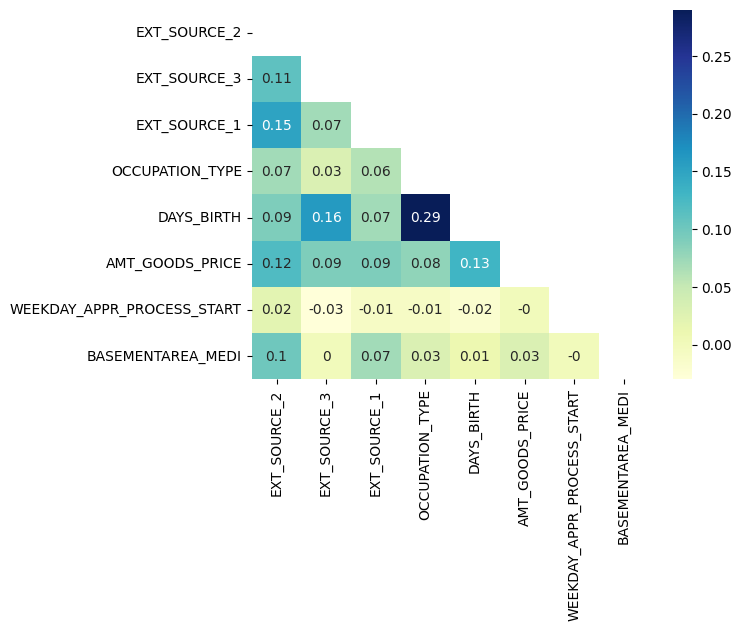

In [69]:
vif_result = get_main_stats_for_the_best_model(
    clf=the_best_model,
    best_combination=best_combination, 
    X_train=X_train_enc,
    y_train=y_train,
    X_val=X_test_enc,
    y_val=y_test,
    X_test=None,
    y_test=None,
)
vif_result

Модель удовлетворяет нашим требованиям к значениям p-value, знакам коэффициентов перед WoE факторами, показателям VIF и всем нашим требованиям к биннингу. Мы произвели корректировки биннинга и незначительно потеряли в качестве наших моделей, но застраховали модель от проблем в будущем.

Из-за недостаточности выводимой optbinning информацией по статистикам для наших выборок валидационной и тестовой реализуем расчет наиболее важных из них самостоятельно

In [70]:
def get_binned_table_for_top_factors(
    X_train: pd.DataFrame,
    y_train: pd.DataFrame,
    X_val: pd.DataFrame,
    y_val: pd.DataFrame,
    X_test: Optional[pd.DataFrame],
    y_test: Optional[pd.DataFrame],
    target_name: str,
    features:List[str], 
    woe_encoder: BinningProcess,
    significant_digits_woe:int=6
) -> pd.DataFrame:
    """Функция для получения основных статистик по выборкам, по итогам применения WoE энкодинга"""
    
    from optbinning.binning.metrics import gini
    
    stats = []
    for n, feature_name in enumerate(features):
        
        binned_table = woe_encoder.get_binned_variable(feature_name).binning_table.build()
        
        bins_woe_dict = {}
        for bin_name, woe_value in zip(binned_table['Bin'], binned_table['WoE']):
            bins_woe_dict[str(bin_name)] = round(woe_value, significant_digits_woe) if isinstance(woe_value, float) else ''
            
        train_n_obs_all = X_train.shape[0]
        train_n_bad_all = y_train.sum()
        train_n_good_all = train_n_obs_all - train_n_bad_all
        
        val_n_obs_all = X_val.shape[0]
        val_n_bad_all = y_val.sum()
        val_n_good_all = val_n_obs_all - val_n_bad_all
        
        if (X_test is not None) & (y_test is not None):
            test_n_obs_all = X_test.shape[0]
            test_n_bad_all = y_test.sum()
            test_n_good_all = test_n_obs_all - test_n_bad_all
        
        X_train_with_target = pd.concat([X_train, y_train], axis=1)
        X_val_with_target = pd.concat([X_val, y_val], axis=1)
        if X_test is not None:
            X_test_with_target = pd.concat([X_test, y_test], axis=1)
        
        for bucket_name, bucket_value_rnd in bins_woe_dict.items():

            train_bucket_df = X_train_with_target.loc[
                X_train_with_target[feature_name].round(significant_digits_woe) == bucket_value_rnd
            ]
            
            val_bucket_df = X_val_with_target.loc[
                X_val_with_target[feature_name].round(significant_digits_woe) == bucket_value_rnd
            ]
            
            if X_test is not None:
                test_bucket_df = X_test_with_target.loc[
                    X_test_with_target[feature_name].round(significant_digits_woe) == bucket_value_rnd
                ]
            
            train_n_obs = train_bucket_df.shape[0]
            val_n_obs = val_bucket_df.shape[0]
            if X_test is not None:
                test_n_obs = test_bucket_df.shape[0]
                
            if train_n_obs == 0:
                continue
            
            train_sh_obs = round(train_n_obs / train_n_obs_all, 6)
            val_sh_obs = round(val_n_obs / val_n_obs_all, 6)
            if X_test is not None:
                test_sh_obs = round(test_n_obs / test_n_obs_all, 6)
            
            train_n_bad = train_bucket_df[target_name].sum()
            val_n_bad = val_bucket_df[target_name].sum()
            if X_test is not None:
                test_n_bad = test_bucket_df[target_name].sum()
            
            train_sh_bad = round(train_n_bad / train_n_bad_all, 6)
            val_sh_bad = round(val_n_bad / val_n_bad_all, 6)
            if X_test is not None:
                test_sh_bad = round(test_n_bad / test_n_bad_all, 6)
            
            train_n_good = train_n_obs - train_n_bad
            val_n_good = val_n_obs - val_n_bad
            if X_test is not None:
                test_n_good = test_n_obs - test_n_bad
            
            train_sh_good = round(train_n_good / train_n_good_all, 6)
            val_sh_good = round(val_n_good / val_n_good_all, 6)
            if X_test is not None:
                test_sh_good = round(test_n_good / test_n_good_all, 6)
            
            train_badrate = round(train_n_bad / train_n_obs, 6)
            val_badrate = round(val_n_bad / val_n_obs, 6)
            if X_test is not None:
                test_badrate = round(test_n_bad / test_n_obs, 6)
            
            train_woe = np.log( (train_n_good * train_n_bad_all) / (train_n_bad * train_n_good_all) )
            val_woe = np.log( (val_n_good * val_n_bad_all) / (val_n_bad * val_n_good_all) )
            if X_test is not None:
                test_woe = np.log( (test_n_good * test_n_bad_all) / (test_n_bad * test_n_good_all) )
            
            iv_train = train_woe * ( (train_n_good / train_n_good_all) - (train_n_bad / train_n_bad_all) )
            iv_val = val_woe * ( (val_n_good / val_n_good_all) - (val_n_bad / val_n_bad_all) )
            if X_test is not None:
                iv_test = test_woe * ( (test_n_good / test_n_good_all) - (test_n_bad / test_n_bad_all) )
        
          
            stats.append(
                {
                    'factor_name': feature_name,
                    'bucket_name': bucket_name,
                    'woe_rnd': bucket_value_rnd,
                    'train_n_obs': train_n_obs,
                    'val_n_obs': val_n_obs,
                    'test_n_obs': test_n_obs if X_test is not None else np.nan,
                    'train_sh_obs': train_sh_obs,
                    'val_sh_obs': val_sh_obs,
                    'test_sh_obs': test_sh_obs if X_test is not None else np.nan,
                    'train_n_bad': train_n_bad,
                    'val_n_bad': val_n_bad,
                    'test_n_bad': test_n_bad if X_test is not None else np.nan,
                    'train_sh_bad': train_sh_bad,
                    'val_sh_bad': val_sh_bad,
                    'test_sh_bad': test_sh_bad if X_test is not None else np.nan,
                    'train_n_good': train_n_good,
                    'val_n_good': val_n_good,
                    'test_n_good': test_n_good if X_test is not None else np.nan,
                    'train_sh_good': train_sh_good,
                    'val_sh_good': val_sh_good,
                    'test_sh_good': test_sh_good if X_test is not None else np.nan,
                    'train_badrate': train_badrate,
                    'val_badrate': val_badrate,
                    'test_badrate': test_badrate if X_test is not None else np.nan,
                    'train_woe': train_woe,
                    'val_woe': val_woe,
                    'test_woe': test_woe if X_test is not None else np.nan,
                    'iv_train': iv_train,
                    'iv_val': iv_val,
                    'iv_test': iv_test if X_test is not None else np.nan,
                }
            )

    return pd.DataFrame(stats)

In [71]:
binned_table_full = get_binned_table_for_top_factors(
    X_train = X_train_enc,
    y_train = y_train,
    X_val = X_test_enc,
    y_val = y_test,
    X_test = None,
    y_test = None,
    target_name=TARGET_NAME,
    features=best_combination, 
    woe_encoder=optimal_binner,
    significant_digits_woe=6
)
print(binned_table_full.shape)
binned_table_full.head()

(31, 30)


,factor_name,bucket_name,woe_rnd,train_n_obs,val_n_obs,test_n_obs,train_sh_obs,val_sh_obs,test_sh_obs,train_n_bad,val_n_bad,test_n_bad,train_sh_bad,val_sh_bad,test_sh_bad,train_n_good,val_n_good,test_n_good,train_sh_good,val_sh_good,test_sh_good,train_badrate,val_badrate,test_badrate,train_woe,val_woe,test_woe,iv_train,iv_val,iv_test
0,EXT_SOURCE_2,"(-inf, 0.14)",-1.118713,443,109,NaN,0.055375,0.0545,NaN,93,30,NaN,0.145540,0.1875,NaN,350,79,NaN,0.047548,0.042935,NaN,0.209932,0.275229,NaN,-1.118713,-1.474097,NaN,0.109625,0.213103,NaN
1,EXT_SOURCE_2,"[0.14, 0.33)",-0.611465,1131,289,NaN,0.141375,0.1445,NaN,156,34,NaN,0.244131,0.2125,NaN,975,255,NaN,0.132455,0.138587,NaN,0.137931,0.117647,NaN,-0.611465,-0.427444,NaN,0.068286,0.031594,NaN
2,EXT_SOURCE_2,"[0.33, 0.48)",-0.223351,1338,338,NaN,0.167250,0.1690,NaN,131,32,NaN,0.205008,0.2000,NaN,1207,306,NaN,0.163972,0.166304,NaN,0.097907,0.094675,NaN,-0.223351,-0.184498,NaN,0.009165,0.006217,NaN
3,EXT_SOURCE_2,"[0.48, 0.61)",0.145677,1977,483,NaN,0.247125,0.2415,NaN,138,24,NaN,0.215962,0.1500,NaN,1839,459,NaN,0.249830,0.249457,NaN,0.069803,0.049689,NaN,0.145677,0.508649,NaN,0.004934,0.050588,NaN
4,EXT_SOURCE_2,"[0.61, 0.71)",0.619046,2105,555,NaN,0.263125,0.2775,NaN,94,32,NaN,0.147105,0.2000,NaN,2011,523,NaN,0.273197,0.284239,NaN,0.044656,0.057658,NaN,0.619046,0.351499,NaN,0.078057,0.029610,NaN


### Визуализируем результаты биннинга

In [72]:
def get_plot_monotonic_bucket(features: List[str], binned_table_full:pd.DataFrame) -> None:
    """Функция для визуализации монотонности преобразований по итогам WoE-энкодинга"""
    
    for feature_name in features:
        
        feature_buckets = binned_table_full.loc[
            binned_table_full['factor_name'] == feature_name
        ]
        
        # Cut bucket name
        feature_buckets['bucket_name'] = feature_buckets['bucket_name'].apply(lambda x: x[:40])
        
        fig, ax = plt.subplots()
        
        fig.set_figheight(3)
        fig.set_figwidth(5)
        ax.bar(feature_buckets['bucket_name'], feature_buckets['train_sh_obs'], width=-0.3, align='edge', edgecolor='k', color='green', alpha=0.5, label='Train')
        ax.bar(feature_buckets['bucket_name'], feature_buckets['val_sh_obs'], width=0.3, align='edge', edgecolor='k', color='orange', alpha=0.7, label='Val')

        ax2 = ax.twinx()
        ax2.plot(feature_buckets['bucket_name'], feature_buckets['train_badrate'], 'ro-', lw=3, label='Train', markeredgecolor='k')
        ax2.plot(feature_buckets['bucket_name'], feature_buckets['val_badrate'], 'go-', lw=3, label='Val', markeredgecolor='k')

        ax.set_ylabel('Bin Count, %')
        ax2.set_ylabel('Event rate')
        ax.set_xlabel('Bin')
        ax.legend(loc=5)
        ax2.legend(loc=1)
        
        ax.tick_params(axis='x', length=0.2, labelsize=6, rotation=45)
    
        plt.title(feature_name)
        
        plt.show()

/var/folders/h5/8301x8nx10170n0w09h2cm8h0000gn/T/ipykernel_7910/4001287977.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feature_buckets['bucket_name'] = feature_buckets['bucket_name'].apply(lambda x: x[:40])


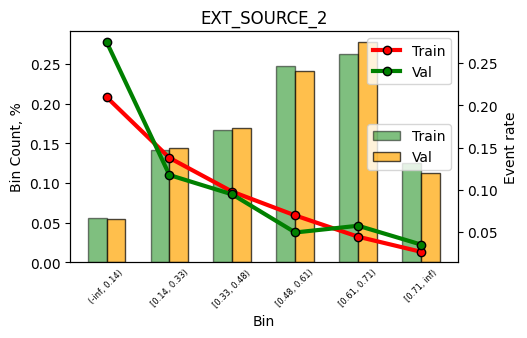

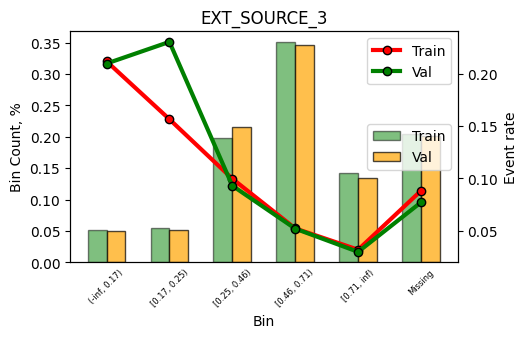

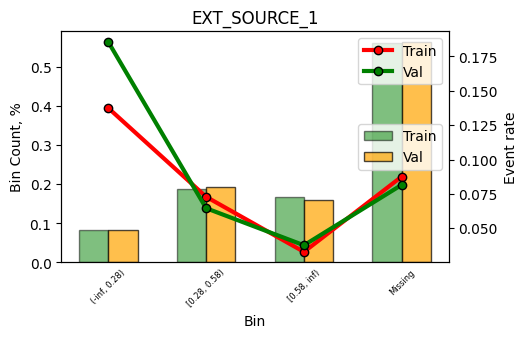

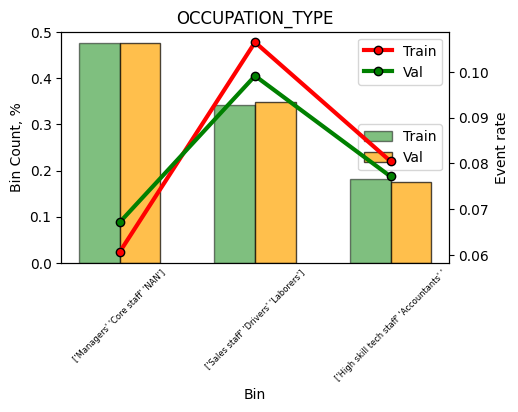

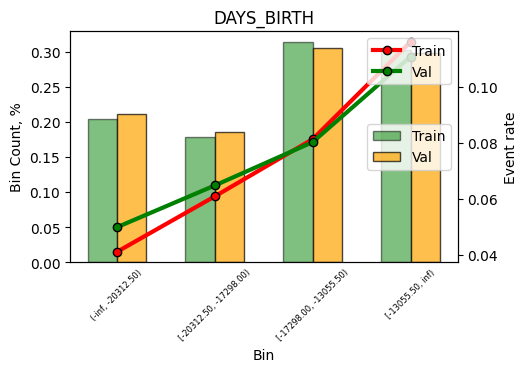

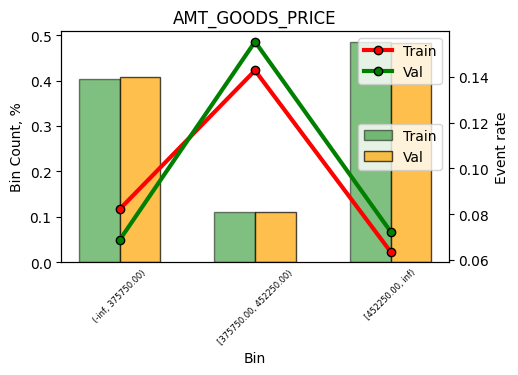

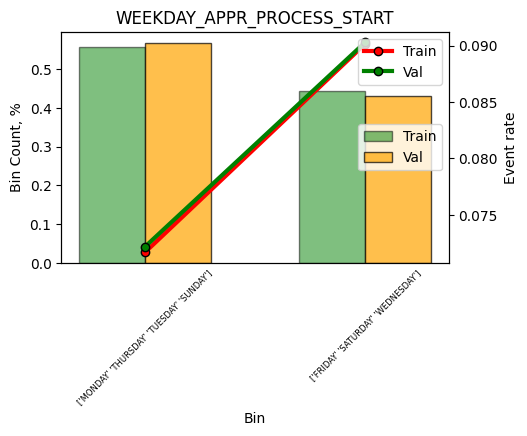

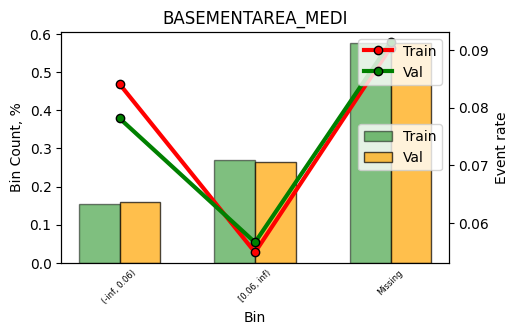

In [73]:
get_plot_monotonic_bucket(best_combination, binned_table_full)

### Строим итоговую модель (скоринговая карта)

In [74]:
from optbinning.scorecard import Scorecard
from sklearn.linear_model import LogisticRegression
from optbinning.scorecard import plot_auc_roc, plot_cap, plot_ks

In [75]:
clf = LogisticRegression(random_state=42)

optimal_binner = ob.BinningProcess(
    variable_names=best_combination,
    categorical_variables=[feature for feature in CATEGORICAL_COLS if feature in best_combination],
    binning_fit_params=_ob_params,
    verbose=True,
    n_jobs=-1,
)

scorecard = Scorecard(
    estimator=clf, 
    binning_process=optimal_binner,
    scaling_method="min_max",
    scaling_method_params={"min": 300, "max": 850}
)


In [76]:
scorecard.fit(X_train[best_combination], y_train, show_digits=4)

Scorecard(binning_process=BinningProcess(binning_fit_params={'AMT_ANNUITY': {'cat_cutoff': 0.05,
                                                                             'divergence': 'iv',
                                                                             'dtype': 'numerical',
                                                                             'max_n_bins': 10,
                                                                             'max_n_prebins': 20,
                                                                             'max_pvalue': 0.05,
                                                                             'max_pvalue_policy': 'all',
                                                                             'min_bin_n_event': 25,
                                                                             'min_bin_n_nonevent': 50,
                                                                             'min_bin_size': 0.05,
                                                                             'min_prebin_size': 0.05,
                                                                             'monotonic_trend': 'auto',
                                                                             'prebinning_method': 'cart'...
                                         categorical_variables=['OCCUPATION_TYPE',
                                                                'WEEKDAY_APPR_PROCESS_START'],
                                         n_jobs=-1,
                                         variable_names=['EXT_SOURCE_2',
                                                         'EXT_SOURCE_3',
                                                         'EXT_SOURCE_1',
                                                         'OCCUPATION_TYPE',
                                                         'DAYS_BIRTH',
                                                         'AMT_GOODS_PRICE',
                                                         'WEEKDAY_APPR_PROCESS_START',
                                                         'BASEMENTAREA_MEDI'],
                                         verbose=True),
          estimator=LogisticRegression(random_state=42),
          scaling_method='min_max',
          scaling_method_params={'max': 850, 'min': 300})

In [77]:
scorecard.information(print_level=2)

optbinning (Version 0.17.3)
Copyright (c) 2019-2022 Guillermo Navas-Palencia, Apache License 2.0

  Begin options
    binning_process                      yes   * U
    estimator                            yes   * U
    scaling_method                   min_max   * U
    scaling_method_params                yes   * U
    intercept_based                    False   * d
    reverse_scorecard                  False   * d
    rounding                           False   * d
    verbose                            False   * d
  End options

  Statistics
    Number of records                   8000
    Number of variables                    8
    Target type                       binary

    Number of numerical                    6
    Number of categorical                  2
    Number of selected                     8

  Timing
    Total time                          0.40 sec
    Binning process                     0.38 sec   ( 93.82%)
    Estimator                           0.02 sec   (  3.94%

In [78]:
scorecard

Scorecard(binning_process=BinningProcess(binning_fit_params={'AMT_ANNUITY': {'cat_cutoff': 0.05,
                                                                             'divergence': 'iv',
                                                                             'dtype': 'numerical',
                                                                             'max_n_bins': 10,
                                                                             'max_n_prebins': 20,
                                                                             'max_pvalue': 0.05,
                                                                             'max_pvalue_policy': 'all',
                                                                             'min_bin_n_event': 25,
                                                                             'min_bin_n_nonevent': 50,
                                                                             'min_bin_size': 0.05,
                                                                             'min_prebin_size': 0.05,
                                                                             'monotonic_trend': 'auto',
                                                                             'prebinning_method': 'cart'...
                                         categorical_variables=['OCCUPATION_TYPE',
                                                                'WEEKDAY_APPR_PROCESS_START'],
                                         n_jobs=-1,
                                         variable_names=['EXT_SOURCE_2',
                                                         'EXT_SOURCE_3',
                                                         'EXT_SOURCE_1',
                                                         'OCCUPATION_TYPE',
                                                         'DAYS_BIRTH',
                                                         'AMT_GOODS_PRICE',
                                                         'WEEKDAY_APPR_PROCESS_START',
                                                         'BASEMENTAREA_MEDI'],
                                         verbose=True),
          estimator=LogisticRegression(random_state=42),
          scaling_method='min_max',
          scaling_method_params={'max': 850, 'min': 300})

In [79]:
sc = scorecard.table(style="summary")

In [80]:
sc

,Variable,Bin,Points
0,EXT_SOURCE_2,"(-inf, 0.1437)",-9.402558
1,EXT_SOURCE_2,"[0.1437, 0.3293)",26.802730
2,EXT_SOURCE_2,"[0.3293, 0.4823)",54.504762
3,EXT_SOURCE_2,"[0.4823, 0.6104)",80.844456
4,EXT_SOURCE_2,"[0.6104, 0.7098)",114.631618
5,EXT_SOURCE_2,"[0.7098, inf)",152.289717
6,EXT_SOURCE_2,Special,70.446629
7,EXT_SOURCE_2,Missing,70.446629
0,EXT_SOURCE_3,"(-inf, 0.1710)",-10.219226
1,EXT_SOURCE_3,"[0.1710, 0.2546)",16.238193


In [81]:
y_pred_train = scorecard.predict_proba(X_train)[:, 1]
# y_pred_val = scorecard.predict_proba(X_val)[:, 1]
y_pred_test = scorecard.predict_proba(X_test)[:, 1]

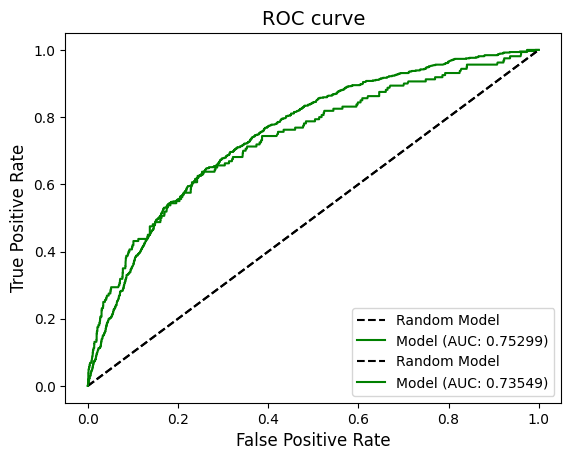

In [82]:
plot_auc_roc(y_train, y_pred_train)
plot_auc_roc(y_test, y_pred_test)

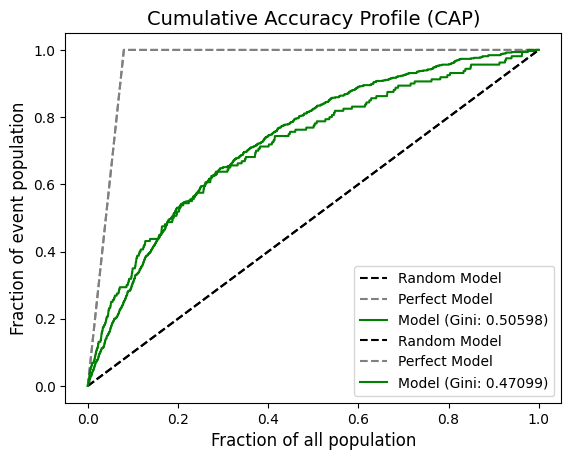

In [83]:
plot_cap(y_train, y_pred_train)
plot_cap(y_test, y_pred_test)

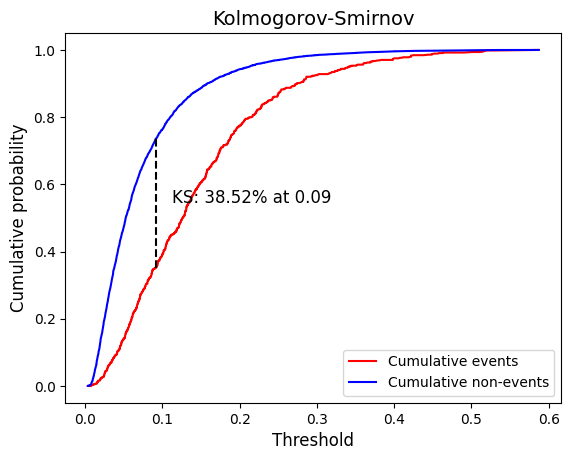

In [84]:
plot_ks(y_train, y_pred_train)

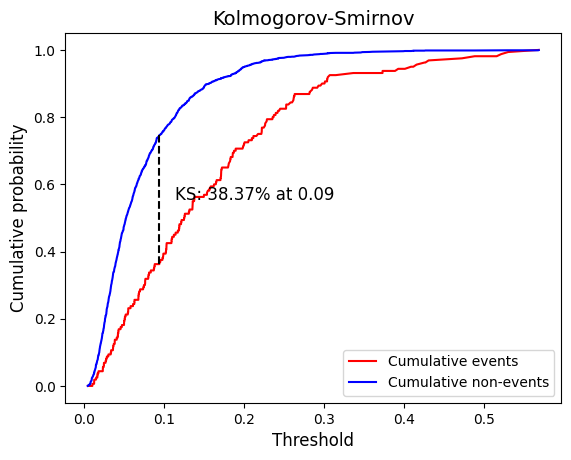

In [85]:
plot_ks(y_test, y_pred_test)

In [86]:
gini_train = gini(y_train, y_pred_train)
gini_test = gini(y_test, y_pred_test)

print(gini_train, gini_test, sep='\n')

0.5059811692081877
0.470985054347826


In [87]:
roc_auc_train = roc_auc_score(y_train, y_pred_train)
roc_auc_test = roc_auc_score(y_test, y_pred_test)

print(roc_auc_train, roc_auc_test, sep='\n')

0.7529905846040938
0.735492527173913


### Сравнение с моделями, обученными с помощью AutoML

In [88]:
train_auc_pipeline_1 = 0.7555279601350346
test_auc_pipeline_1 = 0.7310665760869565

train_auc_pipeline_1_2 = 0.7580085715883249
test_auc_pipeline_1_2 = 0.7344904891304348

train_auc_pipeline_2 = 0.7500913646530726
test_auc_pipeline_2 = 0.7331657608695653
train_auc_pipeline_2_2 = 0.7586795357421285
test_auc_pipeline_2_2 = 0.730679347826087

train_auc_pipeline_3 = 0.6979918272484156
test_auc_pipeline_3 = 0.7158254076086956

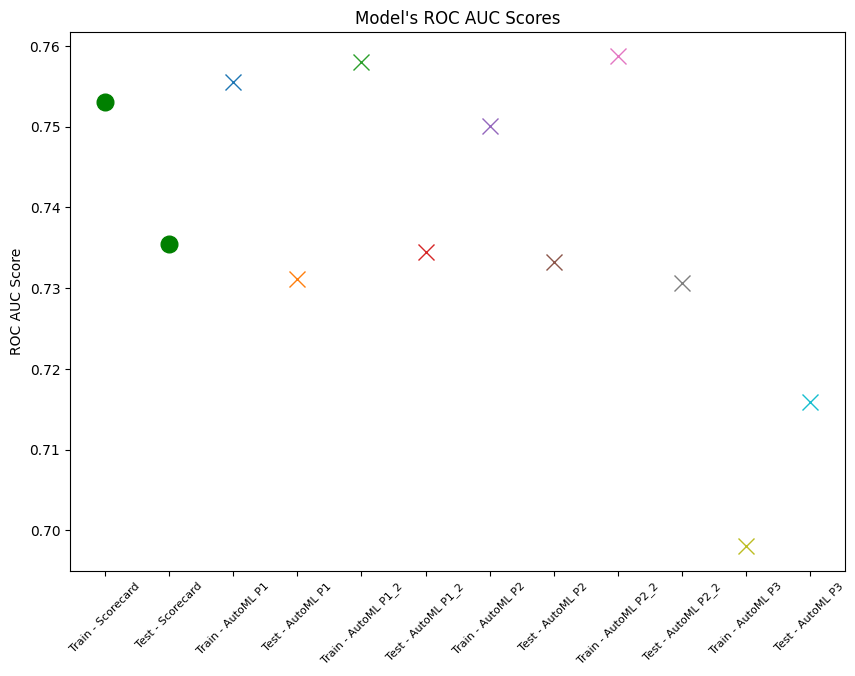

In [89]:
fig, ax = plt.subplots()
fig.set_figheight(7)
fig.set_figwidth(10)

ax.plot('Train - Scorecard', roc_auc_train, marker='o', markersize=12, color='g')
ax.plot('Test - Scorecard', roc_auc_test, marker='o', markersize=12, color='g')

ax.plot('Train - AutoML P1', train_auc_pipeline_1, marker='x', markersize=12)
ax.plot('Test - AutoML P1', test_auc_pipeline_1, marker='x', markersize=12)

ax.plot('Train - AutoML P1_2', train_auc_pipeline_1_2, marker='x', markersize=12)
ax.plot('Test - AutoML P1_2', test_auc_pipeline_1_2, marker='x', markersize=12)

ax.plot('Train - AutoML P2', train_auc_pipeline_2, marker='x', markersize=12)
ax.plot('Test - AutoML P2', test_auc_pipeline_2, marker='x', markersize=12)

ax.plot('Train - AutoML P2_2', train_auc_pipeline_2_2, marker='x', markersize=12)
ax.plot('Test - AutoML P2_2', test_auc_pipeline_2_2, marker='x', markersize=12)

ax.plot('Train - AutoML P3', train_auc_pipeline_3, marker='x', markersize=12)
ax.plot('Test - AutoML P3', test_auc_pipeline_3, marker='x', markersize=12)

ax.set_ylabel('ROC AUC Score')

ax.tick_params(axis='x', labelsize=8, rotation=45)

plt.title("Model's ROC AUC Scores")
plt.show()